The aim of this sub-project is to explore how well our SEM predictor handles different lambda densities in FEP.
Given a range of lambda densities for a selection of FEPs, do FEP-Space SEM values correspond across the range? Do our ML SEM predictions get worse when adjusting the lambda schedule?  Is there anything to gain from using the SEM predictor as a lambda density predictor?

The majority of functions used in this notebook are copied from ../../SETUP_BSS_FOLDERS_TRAINSET.ipynb.
Functions have been adjusted to:
- plot molecular structures while setting up the BSS folders
- set up 33 lambda windows per perturbation -> this can be subselected for MBAR at a later stage.
- set up with 5 ns per window
- set up with the standard BSS protocol instead of editing somd.cfg -> this was fixed in a recent version of BSS.

In [13]:
import BioSimSpace as BSS

from rdkit import Chem
import csv

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

import numpy as np
from tqdm.notebook import tqdm

import subprocess
import os 
import shutil

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Functions copied from ../../SETUP_BSS_FOLDERS_TRAINSET.ipynb

In [14]:
def isRingAromatic(mol, bondRing):
    """Adopted from https://www.rdkit.org/docs/Cookbook.html"""
    for id in bondRing:
        if not mol.GetBondWithIdx(id).GetIsAromatic():
            return False
    return True

def isRingCarbonic(mol, atomRing):
    """Adopted from https://www.rdkit.org/docs/Cookbook.html"""
    for id in atomRing:
        if not mol.GetAtomWithIdx(id).GetAtomicNum() == 6:
            return False
    return True

def flagDoubleBenzenes(input_smiles):
    """Use RDKit to flag molecules that contain more than one benzene moiety."""
    input_mol = Chem.MolFromSmiles(input_smiles)
    
    if not input_mol:
        # in some rare cases RDKit molecule generation from SMILES will fail. Discard these.
        return True
    
    
    ring_atom_info = input_mol.GetRingInfo().AtomRings()
    ring_bond_info = input_mol.GetRingInfo().BondRings()
    
    # in case of only one ring, there is no need to flag the molecule.
    if len(ring_atom_info) == 1:
        return False
    else:
        
        # figure out how many 6-membered rings are aromatic and contain only carbons. Return True if a second 
        # benzene is found.
        ring_sizes = [len(ring) for ring in ring_atom_info]
        if ring_sizes.count(6) == 1:
            return False
        
        benzene_counter = 0
        
        for atoms, bonds in zip(ring_atom_info, ring_bond_info):
            if isRingAromatic(input_mol, bonds):
                if isRingCarbonic(input_mol, atoms):
                    # this means we have caught a benzene. Can be scaffold, so add to counter.
                    benzene_counter += 1
        if benzene_counter > 1:
            return True
        else:
            return False


In [15]:
def getBenzeneScaffoldIndices(molecule):
    """For a given RDKit molecule, return the atom indices for a benzene scaffold"""
    patt = Chem.MolFromSmiles('c1ccccc1')
    hit_ats = list(molecule.GetSubstructMatch(patt))
    return hit_ats, Chem.AddHs(molecule)

In [16]:
def parameteriseLigand(input_ligand):
    """Parameterise an input BSS ligand structure with GAFF2 from SMILES input. returns the parameterised ligand
    and the used SMILES."""
    if os.path.exists("tmp_setup"):
        shutil.rmtree("tmp_setup")
    
    try:
        input_ligand_p = BSS.Parameters.parameterise(input_ligand, forcefield="GAFF2").getMolecule()
    
    except BSS._Exceptions.ParameterisationError:
        # introduce stereochemistry, see https://github.com/openforcefield/openff-toolkit/issues/146
        try:
            input_ligand_p = BSS.Parameters.parameterise(input_ligand.replace("[C]", "[C@H]"), forcefield="GAFF2").getMolecule()
    
        except BSS._Exceptions.ParameterisationError:
            # if it fails again, OFF might be struggling with the input SMILES. For these edge-cases 
            # sometimes it helps shuffling the order of SMILES. Try a few times.
            for attempt in range(5):
                try:
                    # use rdkit to write alternative SMILES.
                    tmpmol = Chem.MolFromSmiles(input_ligand)
                    newsmiles = Chem.MolToSmiles(tmpmol, doRandom=True)
                    print("Retrying with SMILES shuffle:", newsmiles)
                    input_ligand_p = BSS.Parameters.parameterise(newsmiles, forcefield="GAFF2").getMolecule()
                    print("Success!")
                    # return the new smiles as well. 
                    input_ligand = newsmiles
                    break
                    
                except BSS._Exceptions.ParameterisationError:
                    input_ligand_p = None 

        
    if input_ligand_p == None:
        print("Bad input, returning None:", input_ligand)
        
    return input_ligand_p, input_ligand

In [17]:
def getNonAromaticNeighbors(ligand, index, benzene_idces):
    """For a series of neighbors, return the symbol for the non-aromatic one together with the second neighbor."""
    non_aro_neighbor = None
    second_neighbors = None
    
    # in some rare cases RDKit throws a cpp exception:
    #     Violation occurred on line 183 in file Code/GraphMol/ROMol.cpp
    #     Failed Expression: 27 < 27
    # For those cases just ignore this particular scaffold atom.
    try:
        ligand.GetAtomWithIdx(index)
    except:
        return non_aro_neighbor        
    
    # loop over this scaffold atom's neighbours.
    for neighbor in ligand.GetAtomWithIdx(index).GetNeighbors():
        # get first neighbors, exclude benzene scaffold ones.
        if not neighbor.GetIdx() in benzene_idces:
            non_aro_neighbor = neighbor.GetSymbol()
            
            # construct a crude string of the second neighbors. This could be wrong SMILES, but we just need it 
            # for matching R groups.
            second_neighbors = ""
            for second_neighbor in ligand.GetAtomWithIdx(neighbor.GetIdx()).GetNeighbors():
                if not neighbor.GetIsAromatic():
                    second_neighbors += second_neighbor.GetSymbol()
    if second_neighbors:
        non_aro_neighbor += second_neighbors

    return non_aro_neighbor

In [18]:
def isAlreadyHandled(new, handled_list):
    """Checks if the supplied list of faux-SMILES representing a perturbation rotation is already in the 
    provided nested list (of already handled perts)."""
    result_bools = []
    for handled in handled_list:
        result_bools.append(sorted(new) == sorted(handled))
    if any(result_bools):
        return True
    else:
        return False

In [19]:
def depictMol(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """
    Chem.AllChem.Compute2DCoords(mol)
    Draw.MolToFile(mol, "tmp_images/tmp.png")

    img = mpimg.imread("tmp_images/tmp.png")
    
    return img  

In [20]:
def rdkitPerturbableMolecule(pdb_path, ignore_bond_orders):
    """Using RDKit, return a molecule that has dummy atoms (written by BSS)"""
    if not ignore_bond_orders:
        # convert to mol2 to restore bond orders.
        mol2_path = pdb_path.replace(".pdb", ".mol2")

        subprocess.call(f"obabel -ipdb {pdb_path} -O {mol2_path}", shell=True)

        with open(mol2_path, "r") as file:
            lig_mol2_block = file.read()

        # read into mol object.
        parsed_mol = Chem.MolFromMol2Block(lig_mol2_block.replace("Du", "At"), 
                                            sanitize=False)
        
    elif ignore_bond_orders:
        with open(pdb_path, "r") as file:
            lig_pdb_block = file.read()

        # read into mol object.
        parsed_mol = Chem.MolFromPDBBlock(lig_pdb_block.replace("XX", "AT"), 
                                            sanitize=False, proximityBonding=False)

    # replace astatin in molecule with dummy notation.
    [a.SetProp("_displayLabel", "Du") for a in parsed_mol.GetAtoms() if a.GetAtomicNum() == 85]
        
        
    # set up molecule structure.
    parsed_mol = Chem.RemoveHs(parsed_mol, sanitize=False)
    
    Chem.rdmolops.RemoveStereochemistry(parsed_mol)
    Chem.AllChem.Compute2DCoords(parsed_mol)
    
    return parsed_mol

In [50]:
def setupFEPwithBSS(lig_1, lig_2, mapping, pertname, target, dataset_type, lig_1_smi, lig_2_smi, pert_smarts, depict):
    """Use BSS to setup a FEP folder with the specified mapping. See BSS docs for general approach."""
    
    lig_1_a = BSS.Align.rmsdAlign(lig_1, lig_2, mapping)
    
    # merge while catching BSS IncompatibleErrors. These are rare errors that have to do with fused ring
    # mapping issues and only occur once per rotation for these cases. These can be safely excluded as 
    # the main perturbation is conserved in FEP-space.
    try:
        merged = BSS.Align.merge(lig_1_a, lig_2, mapping,
                            allow_ring_breaking=True,
                            allow_ring_size_change=True
                            )
    except BSS._Exceptions.IncompatibleError:
        print(f"Skipped {lig_1}~{lig_2}, {target}, {mapping}")
        return None
        
    if depict:
        print(dataset_type)
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

        img0 = depictMol(Chem.MolFromSmiles(lig_1_smi))
        img1 = depictMol(Chem.MolFromSmiles(lig_2_smi))

        # merged mol.
        BSS.IO.saveMolecules("tmp_images/m0.pdb", merged._toRegularMolecule(is_lambda1=False), "PDB")
        BSS.IO.saveMolecules("tmp_images/m1.pdb", merged._toRegularMolecule(is_lambda1=True), "PDB")
        
        try:
            merged0_rdkit = rdkitPerturbableMolecule("tmp_images/m0.pdb", ignore_bond_orders=False)
            merged1_rdkit = rdkitPerturbableMolecule("tmp_images/m1.pdb", ignore_bond_orders=False)

            img2 = depictMol(merged0_rdkit)
            img3 = depictMol(merged1_rdkit)
        except:
            # at this point if rdkit (kekulization) fails we can continue without bond orders instead.
            # 
            print("Removing bond ordering because dummy atoms break RDKit kekulization.")
            merged0_rdkit = rdkitPerturbableMolecule("tmp_images/m0.pdb", ignore_bond_orders=True)
            merged1_rdkit = rdkitPerturbableMolecule("tmp_images/m1.pdb", ignore_bond_orders=True)

            img2 = depictMol(merged0_rdkit)
            img3 = depictMol(merged1_rdkit)           

        # show mols in subplots.
        axes[0].imshow(img0)
        axes[1].imshow(img1)
        axes[2].imshow(img2)
        axes[3].imshow(img3)
        
        
        for ax in axes:
            ax.axis("off")
        plt.show()
        
        

    solvated = BSS.Solvent.tip3p(molecule=merged, box=3*[3*BSS.Units.Length.nanometer])

    protocol = BSS.Protocol.FreeEnergy(num_lam=33, runtime=5*BSS.Units.Time.nanosecond)

    # set up one folder to cp later (i.e. quintuplicate).
    somd_path = f"FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/rep_"

    BSS.FreeEnergy.Relative(    solvated, 
                                protocol, 
                                engine="SOMD",
                                setup_only=True,
                                work_dir=somd_path
                                )


    # make a file that contains information on this pert.
    with open(f"FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/pert_info.txt", "w") as infofile:
        writer = csv.writer(infofile)
        writer.writerow([f"INFO ON PERT"])
        writer.writerow([f"MAPPING: {mapping}"])
        writer.writerow([f"LIG_1_SMILES: {lig_1_smi}"])
        writer.writerow([f"LIG_2_SMILES: {lig_2_smi}"])
        writer.writerow([f"PERTURBATION SMARTS: {pert_smarts}"])

    # make the quintuplicate.
    for i in range(4):
        subprocess.call(f"cp -r FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/rep_ FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/rep_{i+1}", shell=True)

    subprocess.call(f"mv FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/rep_ FEPSPACE_TRAIN/{dataset_type}/{target}/{pertname}/rep_5", shell=True)

# SETUP

In [51]:
# first get the perturbations to setup. We want to examine some low-SEM perturbations and 
# some high-SEM ones (in FEP-Space). 

benzene_quints = []
with open("../fepspace_vs_free_vs_bound/compiled_mbar_freenrgs_fepspace.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        benzene_quints.append([row[0].replace("lig_", ""), float(row[-1])])
benzene_quints.sort(key = lambda x: x[1])

In [52]:
# retrieve the SMILES (and some other information) for these perturbations.
retrieved_quints = []
for pert_descriptor in benzene_quints:

    tgt = pert_descriptor[0].split("_")[-1]
    pert = "_".join(pert_descriptor[0].split("_")[:-1])
    with open("../perturbation_networks/input/fepspace_perts.csv", "r") as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            if row[0] == pert and row[1] == tgt:
                row.append(pert_descriptor[1])
                retrieved_quints.append(row)

benzene_quints_high_sem = retrieved_quints[-6:]
benzene_quints_low_sem = retrieved_quints[:6]

# LOW SEMS:

  0%|          | 0/6 [00:00<?, ?it/s]

out1~out19 shp2
LOW/MAIN


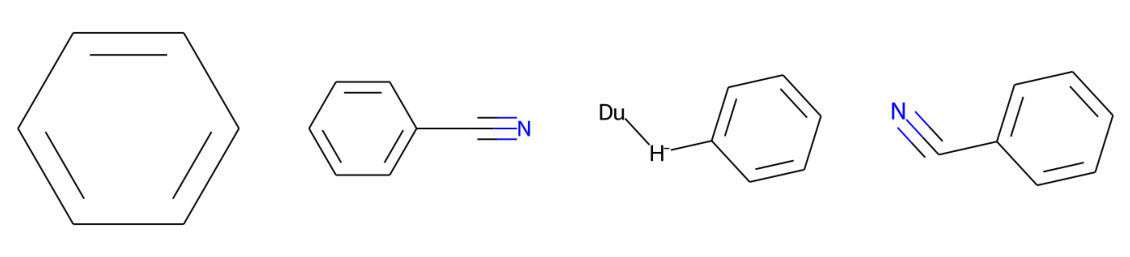

40~41 cdk8
LOW/MAIN


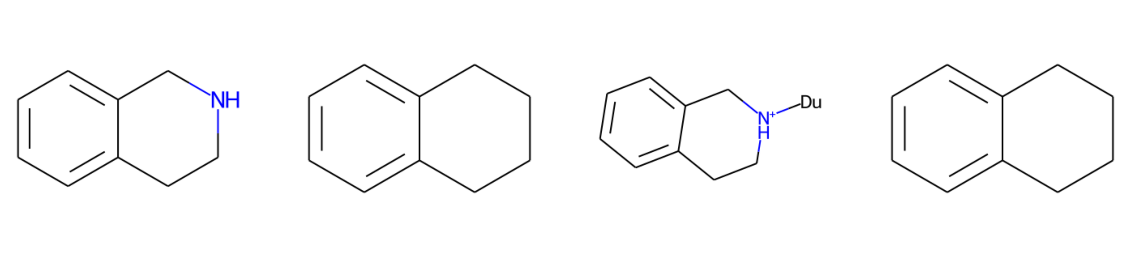

LOW/AUGMENT


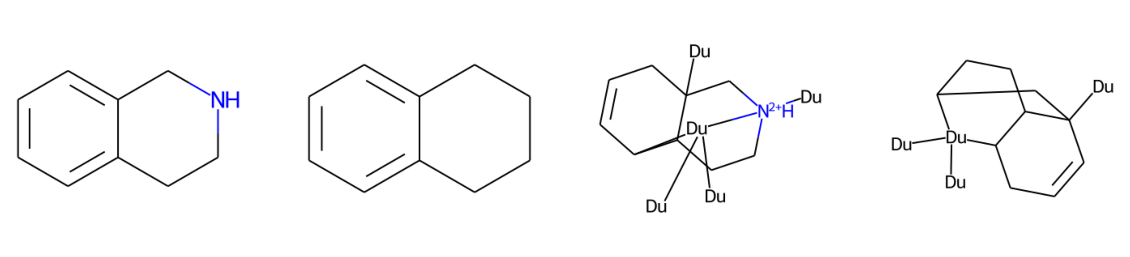

LOW/AUGMENT


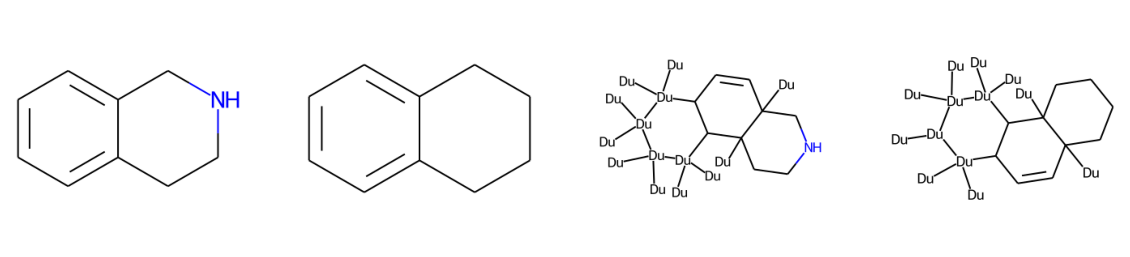

LOW/AUGMENT


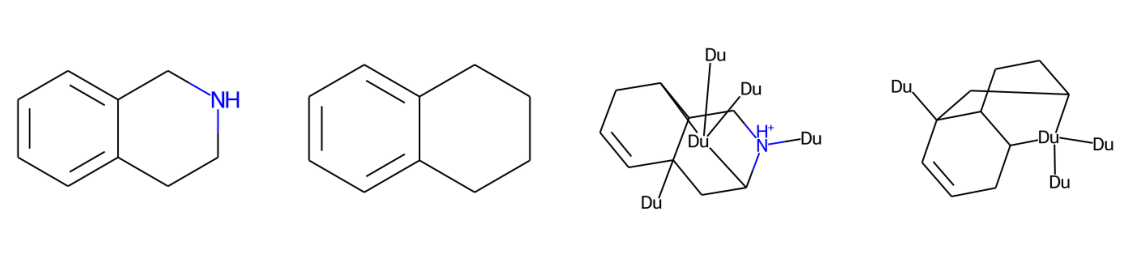

out2~out25 shp2
LOW/MAIN


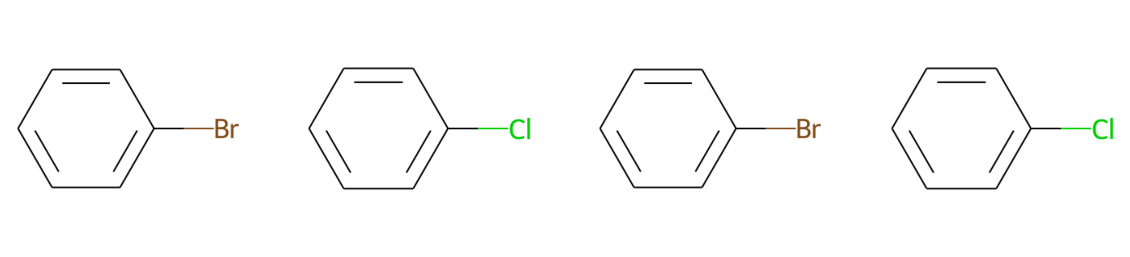

LOW/AUGMENT


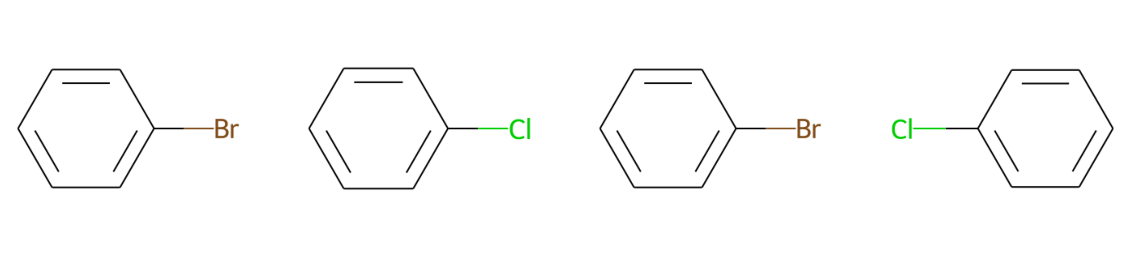

155~164 hif2a
LOW/MAIN


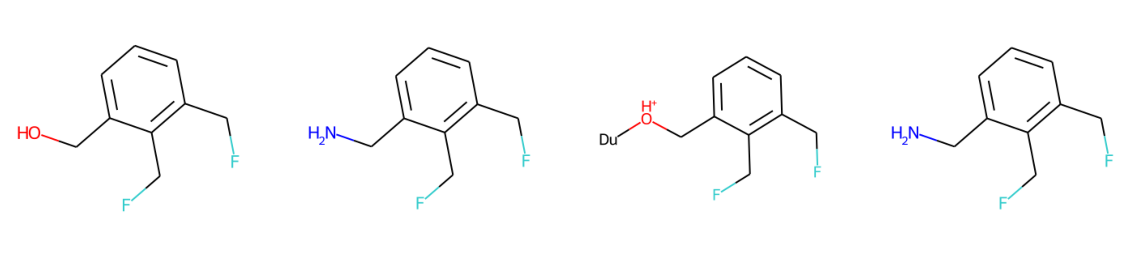

LOW/AUGMENT


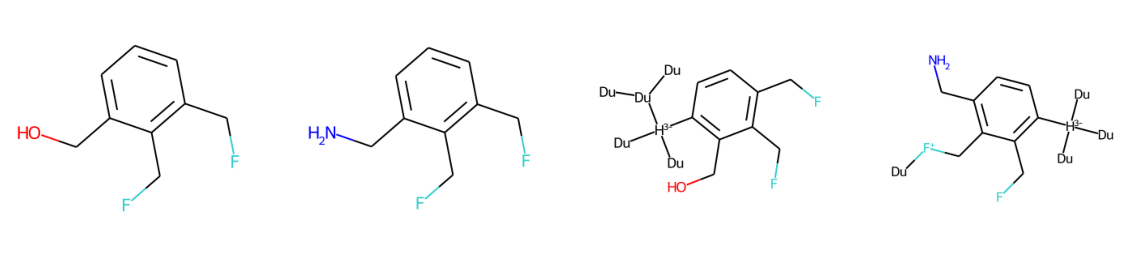

LOW/AUGMENT


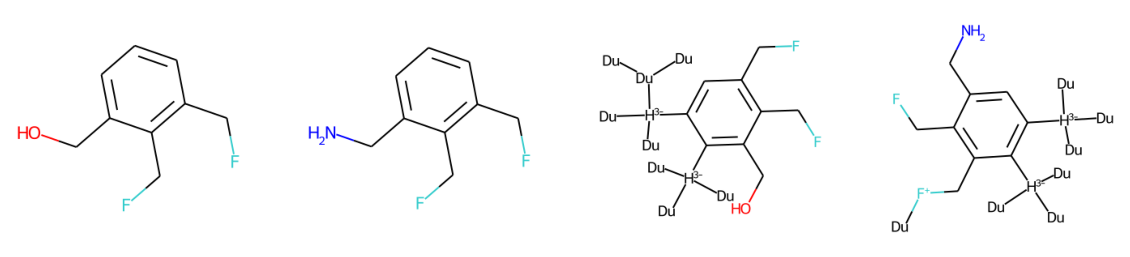

LOW/AUGMENT


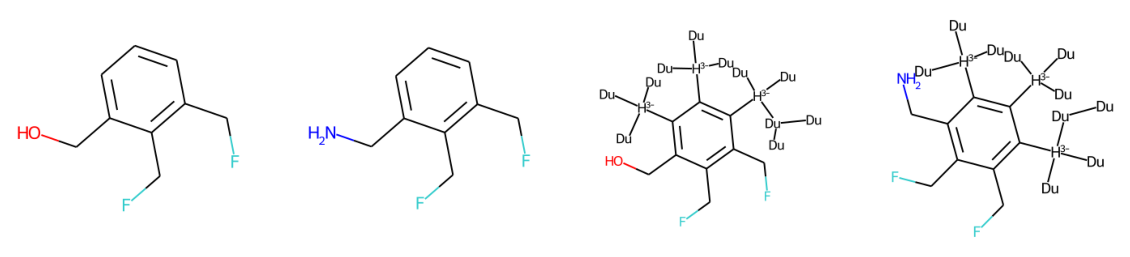

LOW/AUGMENT


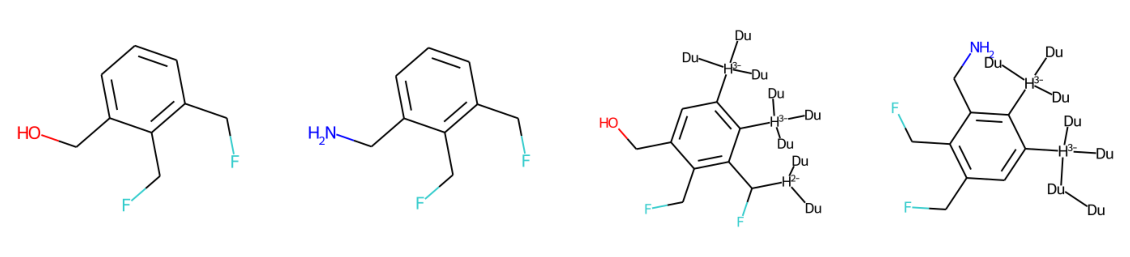

LOW/AUGMENT


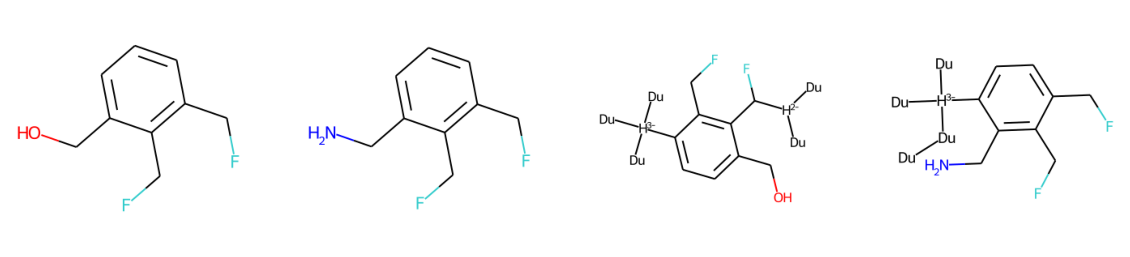

out11~out23 shp2
LOW/MAIN


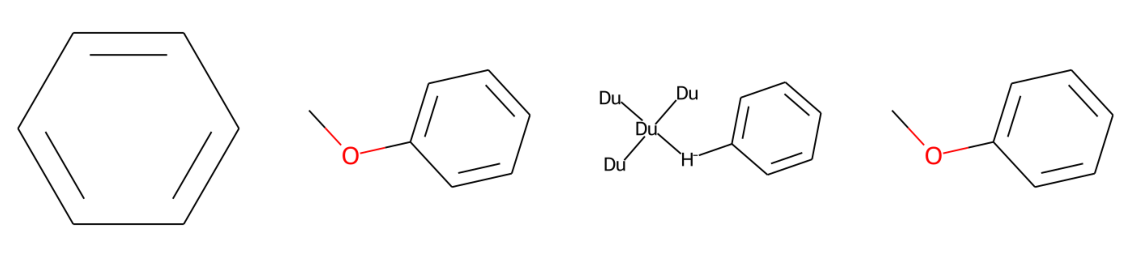

out11~out6 shp2
LOW/MAIN


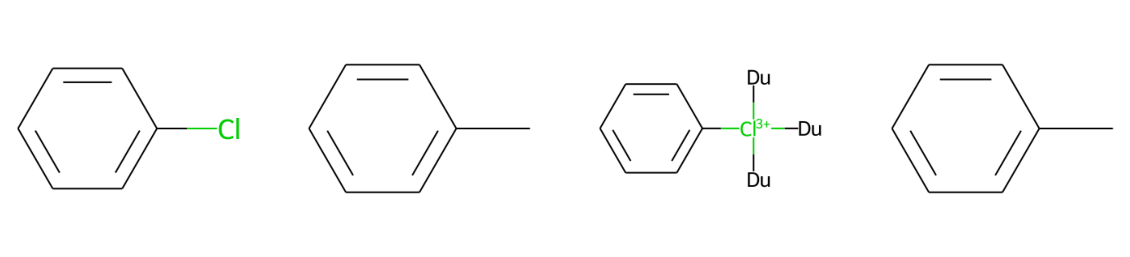

LOW/AUGMENT


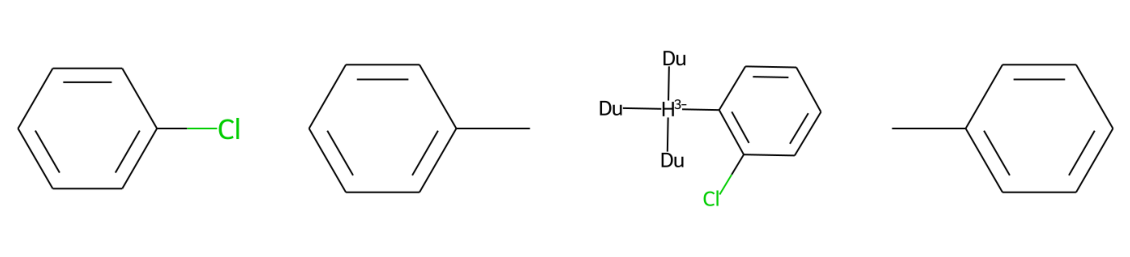

In [53]:
depict_mol_bool = True
skip_existing = True

for pert_entry in tqdm(benzene_quints_low_sem):
    
    ############ LIGAND SETUP
    pert, tgt, n_ha_perturbed, lig_1_smi, lig_2_smi, pert_smarts, sem = pert_entry
       
    if depict_mol_bool:
        print("="*100)
    print(pert, tgt)
    
    lig_1, lig_1_smi = parameteriseLigand(lig_1_smi)
    lig_2, lig_2_smi = parameteriseLigand(lig_2_smi)
    
    if lig_1 == None or lig_2 == None:
        continue
    
    ############ MAPPING GENERATION
    # use RDKit to find the benzene atom indices. These are conserved between RDKit and BSS.
    lig_1_benzene_indices, lig_1_rdkit = getBenzeneScaffoldIndices(Chem.MolFromSmiles(lig_1_smi))
    lig_2_benzene_indices, lig_2_rdkit = getBenzeneScaffoldIndices(Chem.MolFromSmiles(lig_2_smi))


    # with the benzene indices make a forced mapping.
    forced_mapping = {}
    for at1, at2 in zip(lig_1_benzene_indices, lig_2_benzene_indices):
        forced_mapping[at1] = at2

    # use BSS to map the ligands together and merge.
    forced_mapping_bss = BSS.Align.matchAtoms(lig_1, lig_2, prematch=forced_mapping)
    

    ############ MAPPING ROTATIONS
    handled_rotation_perts = []
    bss_mappings = []
    for rotation_iter in range(6):
        rotated_lig_2_indices = lig_2_benzene_indices[-rotation_iter:] + lig_2_benzene_indices[:-rotation_iter]

        # with the benzene indices make a forced mapping.
        forced_mapping = {}
        for at1, at2 in zip(lig_1_benzene_indices, rotated_lig_2_indices):
            forced_mapping[at1] = at2

        # use BSS to map the ligands.
        forced_mapping_bss = BSS.Align.matchAtoms(lig_1, lig_2, prematch=forced_mapping)
        
        # with the mapping provided by BSS, we work out what the perturbation looks like with RDKit. This way
        # we can exclude identical perturbations.
        handled_r_group_perts = []

        ############ MAPPING EXCLUSIONS
        for k,v in forced_mapping_bss.items():

            start_of_r_group_lig_1 = getNonAromaticNeighbors(lig_1_rdkit, k, lig_1_benzene_indices)
            start_of_r_group_lig_2 = getNonAromaticNeighbors(lig_2_rdkit, v, lig_2_benzene_indices)

            # if the R group is HC, signal that this is a non-R group by replacing with 'X'.
            if start_of_r_group_lig_1 == "HC" or start_of_r_group_lig_1 == None:
                start_of_r_group_lig_1 = "X"
            if start_of_r_group_lig_2 == "HC" or start_of_r_group_lig_2 == None:
                start_of_r_group_lig_2 = "X"


            # we now have a faux-SMILES string for the transformation on this index on the benzene scaffold.
            if not start_of_r_group_lig_1 == "X" or not start_of_r_group_lig_2 == "X":

                # if there actually are atoms being perturbed on this index, construct a faux-SMILES for the pert.
                transform_string = start_of_r_group_lig_1+">"+start_of_r_group_lig_2

                # if this pert SMILES has not been added yet, add it to a collector.
                if not transform_string in handled_r_group_perts:
                    handled_r_group_perts.append(transform_string)

        # if this pert SMILES is not yet in the rotation collector, we can set it up with BSS.
        if not isAlreadyHandled(handled_r_group_perts, handled_rotation_perts):            
            handled_rotation_perts.append(handled_r_group_perts)

            bss_mappings.append(forced_mapping_bss)  
    
    ############ BSS FEP FOLDER SETUP
    if len(bss_mappings) == 1:
        # if only one mapping we're dealing with either a vanish or grow perturbation. Simply set up the main pert.
        setupFEPwithBSS(lig_1, lig_2, bss_mappings[0], pert, tgt, "LOW/MAIN", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)
    else:
        # if multiple mappings, the first mapping will be the 'original' one. The others will be augmented dataset.
        setupFEPwithBSS(lig_1, lig_2, bss_mappings[0], pert, tgt, "LOW/MAIN", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)
        non_main_mappings = bss_mappings[1:]
        for i, mapping in enumerate(non_main_mappings):
            setupFEPwithBSS(lig_1, lig_2, mapping, f"{pert}_{i+1}", tgt, "LOW/AUGMENT", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)


# HIGH SEMS:

  0%|          | 0/6 [00:00<?, ?it/s]

CHEMBL1078691~CHEMBL1093088 eg5
HIGH/MAIN


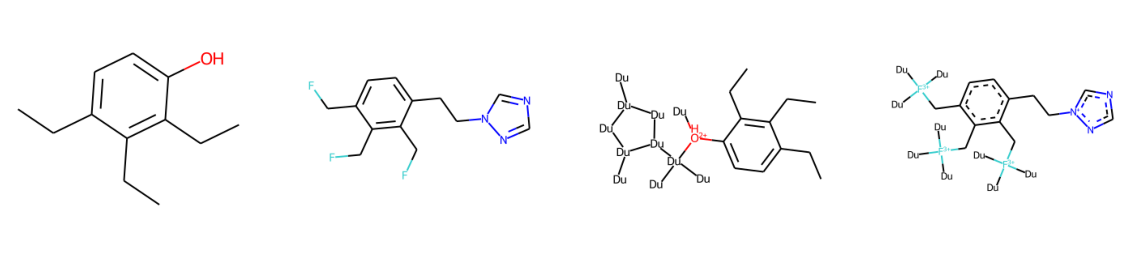

HIGH/AUGMENT


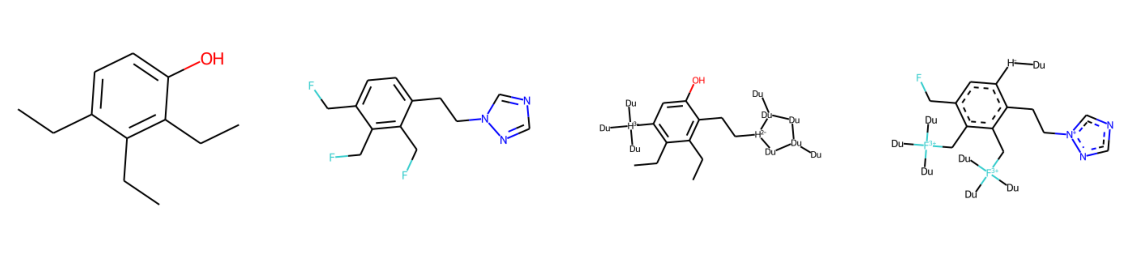

HIGH/AUGMENT


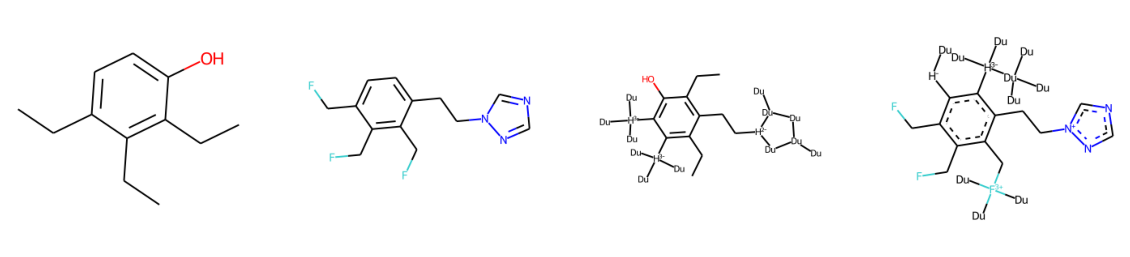

HIGH/AUGMENT


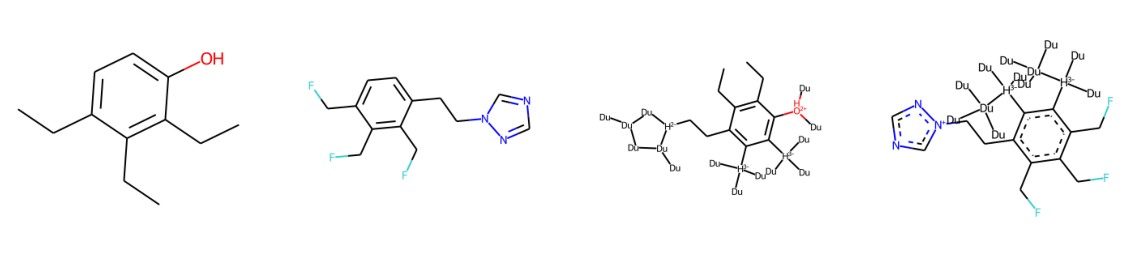

HIGH/AUGMENT


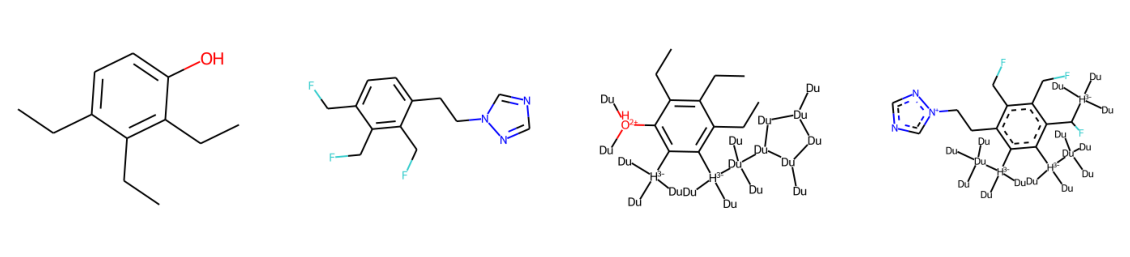

HIGH/AUGMENT


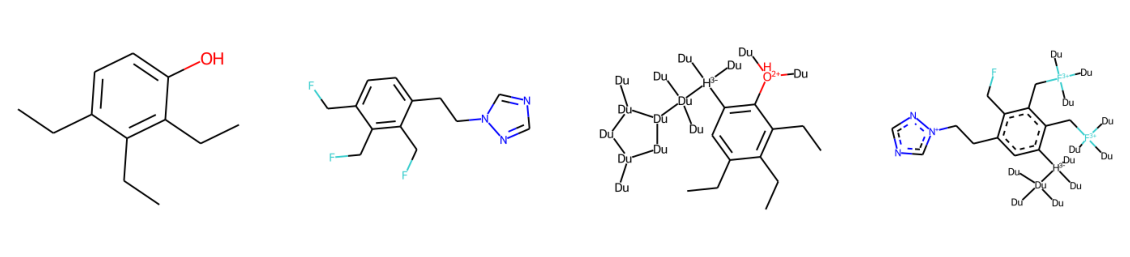

31~19 cdk8
HIGH/MAIN


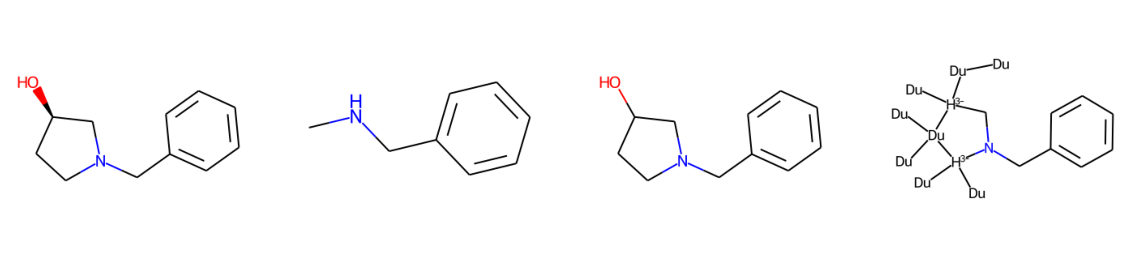

HIGH/AUGMENT


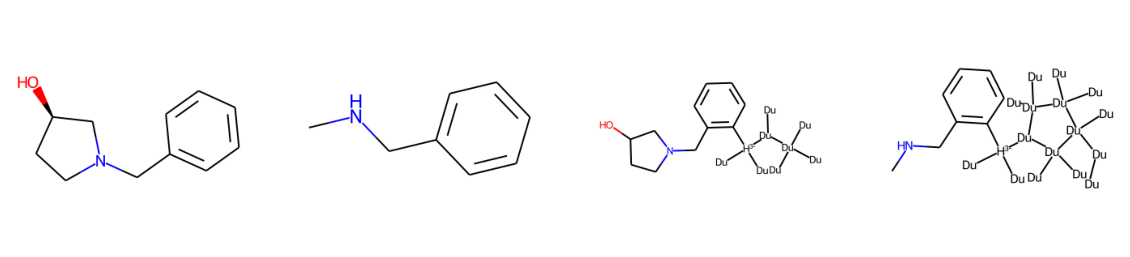

32~40 cdk8
HIGH/MAIN


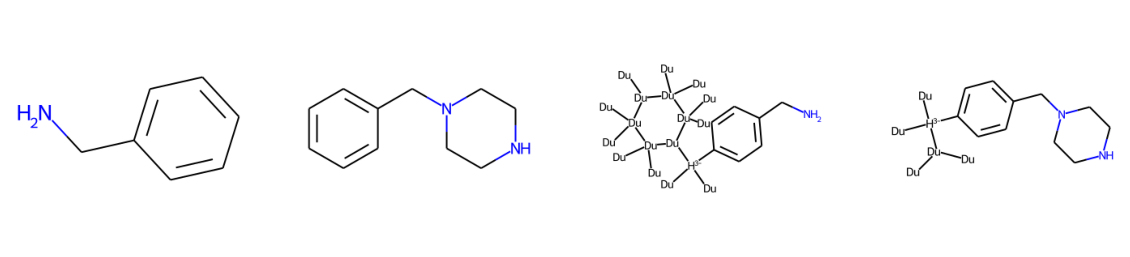

HIGH/AUGMENT


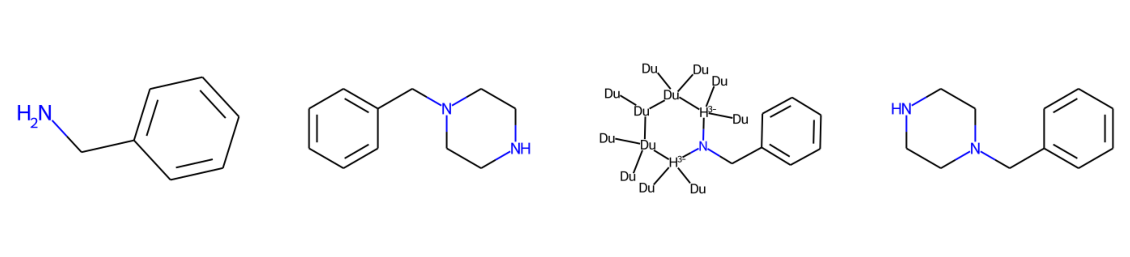

17~43 cdk8
HIGH/MAIN


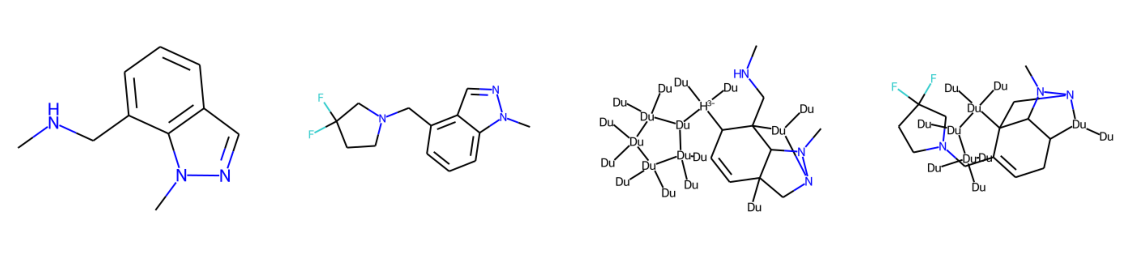

HIGH/AUGMENT


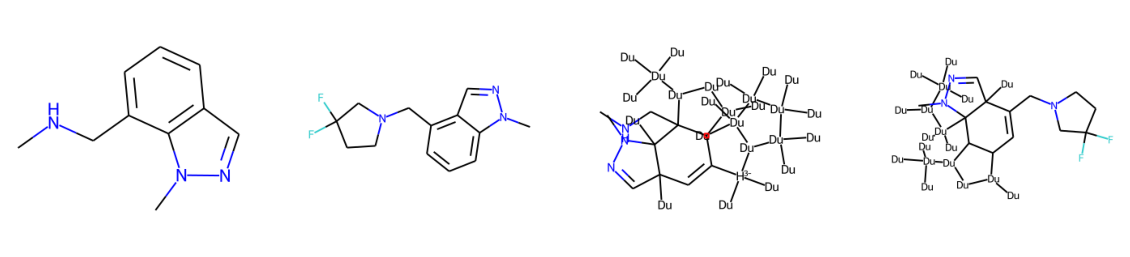

HIGH/AUGMENT


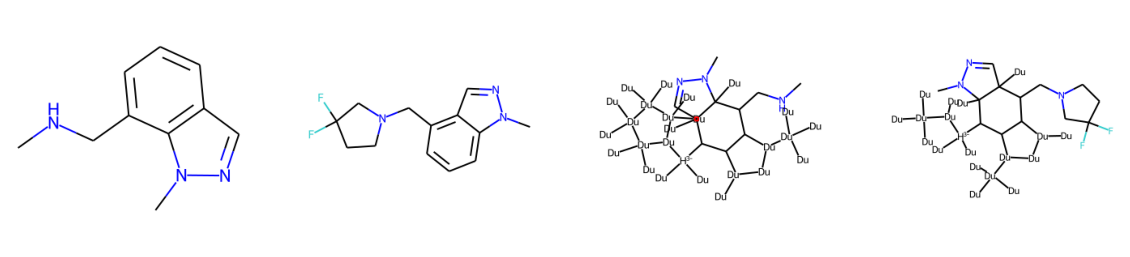

HIGH/AUGMENT


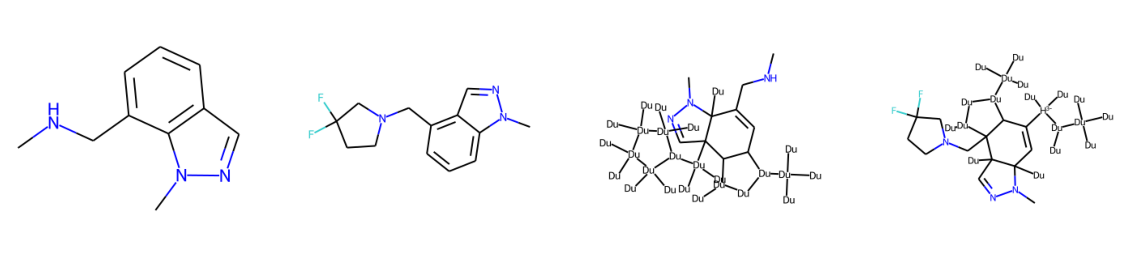

HIGH/AUGMENT


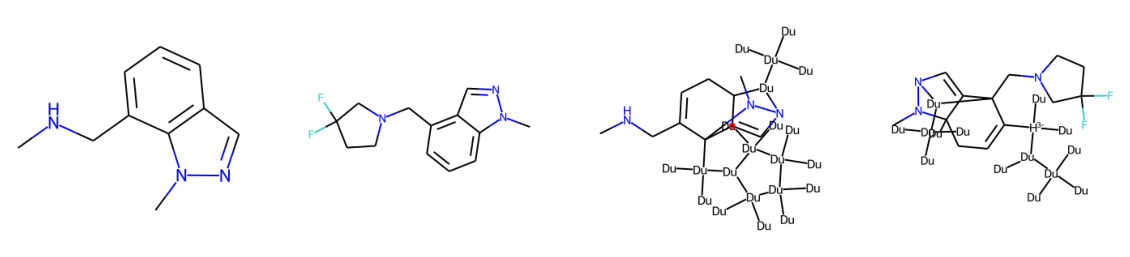

HIGH/AUGMENT


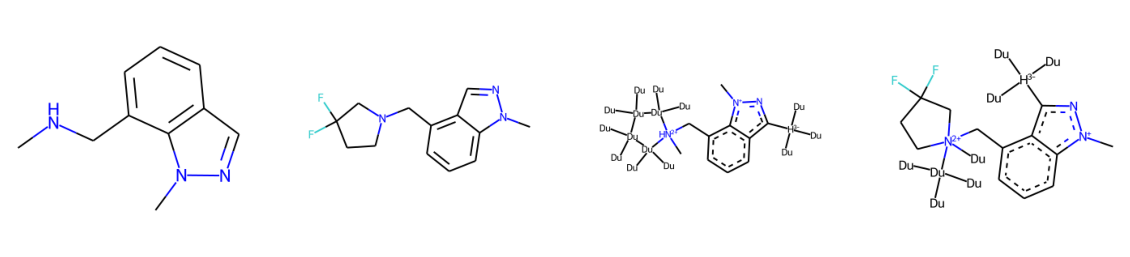

40~20 cdk8
HIGH/MAIN


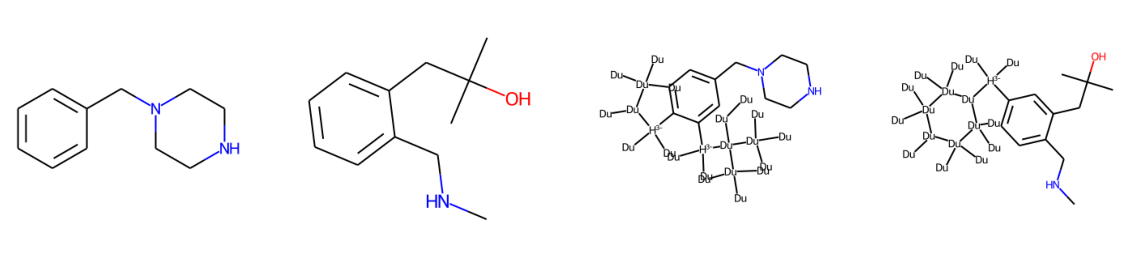

HIGH/AUGMENT


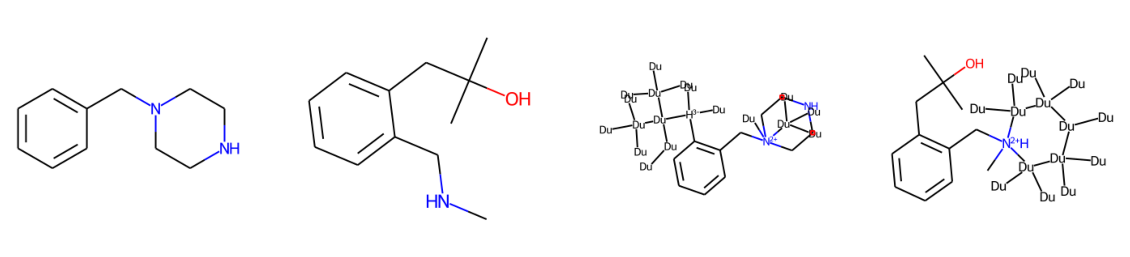

HIGH/AUGMENT


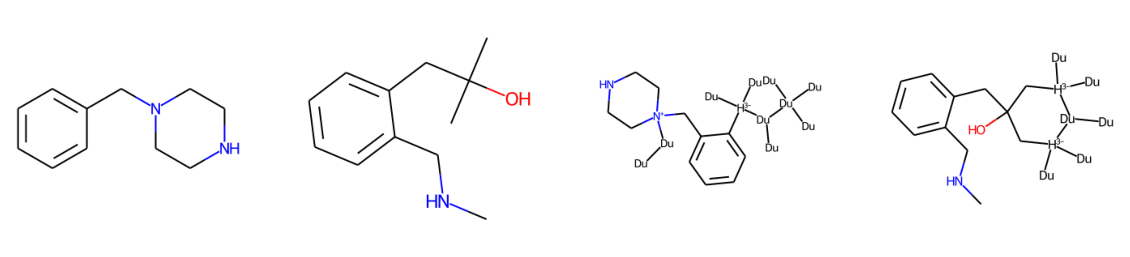

20~34 cdk8
HIGH/MAIN


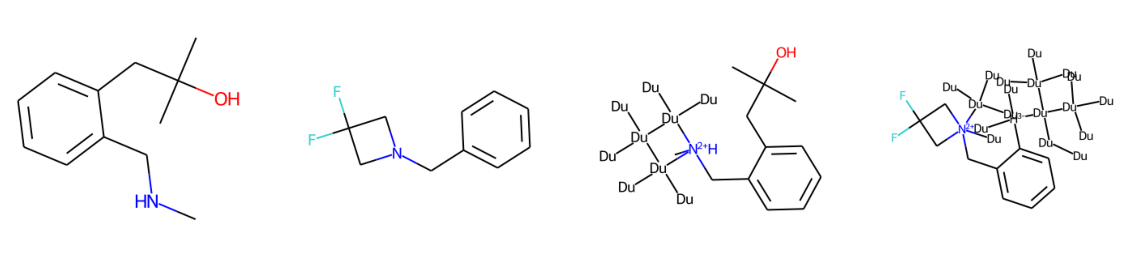

HIGH/AUGMENT


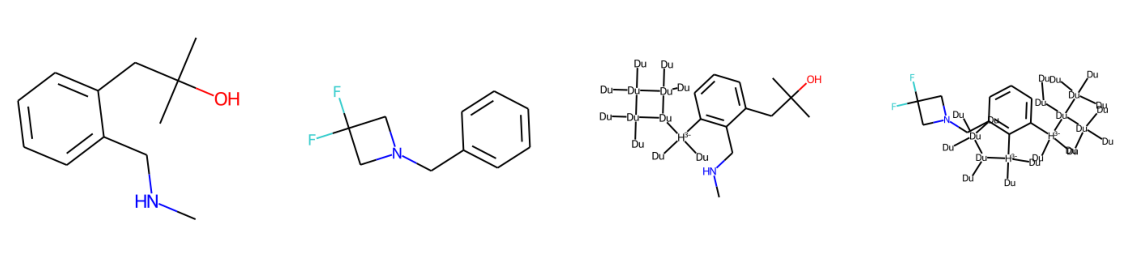

HIGH/AUGMENT


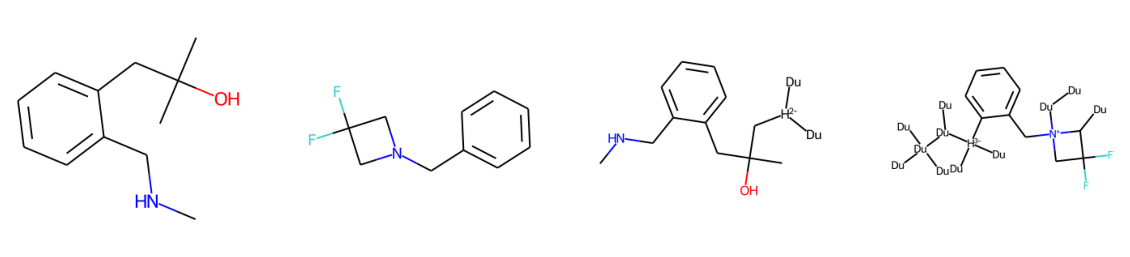

In [54]:
depict_mol_bool = True
skip_existing = True

for pert_entry in tqdm(benzene_quints_high_sem):
    
    ############ LIGAND SETUP
    pert, tgt, n_ha_perturbed, lig_1_smi, lig_2_smi, pert_smarts, sem = pert_entry
       
    if depict_mol_bool:
        print("="*100)
    print(pert, tgt)
    
    lig_1, lig_1_smi = parameteriseLigand(lig_1_smi)
    lig_2, lig_2_smi = parameteriseLigand(lig_2_smi)
    
    if lig_1 == None or lig_2 == None:
        continue
    
    ############ MAPPING GENERATION
    # use RDKit to find the benzene atom indices. These are conserved between RDKit and BSS.
    lig_1_benzene_indices, lig_1_rdkit = getBenzeneScaffoldIndices(Chem.MolFromSmiles(lig_1_smi))
    lig_2_benzene_indices, lig_2_rdkit = getBenzeneScaffoldIndices(Chem.MolFromSmiles(lig_2_smi))


    # with the benzene indices make a forced mapping.
    forced_mapping = {}
    for at1, at2 in zip(lig_1_benzene_indices, lig_2_benzene_indices):
        forced_mapping[at1] = at2

    # use BSS to map the ligands together and merge.
    forced_mapping_bss = BSS.Align.matchAtoms(lig_1, lig_2, prematch=forced_mapping)
    

    ############ MAPPING ROTATIONS
    handled_rotation_perts = []
    bss_mappings = []
    for rotation_iter in range(6):
        rotated_lig_2_indices = lig_2_benzene_indices[-rotation_iter:] + lig_2_benzene_indices[:-rotation_iter]

        # with the benzene indices make a forced mapping.
        forced_mapping = {}
        for at1, at2 in zip(lig_1_benzene_indices, rotated_lig_2_indices):
            forced_mapping[at1] = at2

        # use BSS to map the ligands.
        forced_mapping_bss = BSS.Align.matchAtoms(lig_1, lig_2, prematch=forced_mapping)
        
        # with the mapping provided by BSS, we work out what the perturbation looks like with RDKit. This way
        # we can exclude identical perturbations.
        handled_r_group_perts = []

        ############ MAPPING EXCLUSIONS
        for k,v in forced_mapping_bss.items():

            start_of_r_group_lig_1 = getNonAromaticNeighbors(lig_1_rdkit, k, lig_1_benzene_indices)
            start_of_r_group_lig_2 = getNonAromaticNeighbors(lig_2_rdkit, v, lig_2_benzene_indices)

            # if the R group is HC, signal that this is a non-R group by replacing with 'X'.
            if start_of_r_group_lig_1 == "HC" or start_of_r_group_lig_1 == None:
                start_of_r_group_lig_1 = "X"
            if start_of_r_group_lig_2 == "HC" or start_of_r_group_lig_2 == None:
                start_of_r_group_lig_2 = "X"


            # we now have a faux-SMILES string for the transformation on this index on the benzene scaffold.
            if not start_of_r_group_lig_1 == "X" or not start_of_r_group_lig_2 == "X":

                # if there actually are atoms being perturbed on this index, construct a faux-SMILES for the pert.
                transform_string = start_of_r_group_lig_1+">"+start_of_r_group_lig_2

                # if this pert SMILES has not been added yet, add it to a collector.
                if not transform_string in handled_r_group_perts:
                    handled_r_group_perts.append(transform_string)

        # if this pert SMILES is not yet in the rotation collector, we can set it up with BSS.
        if not isAlreadyHandled(handled_r_group_perts, handled_rotation_perts):            
            handled_rotation_perts.append(handled_r_group_perts)

            bss_mappings.append(forced_mapping_bss)  
    
    ############ BSS FEP FOLDER SETUP
    if len(bss_mappings) == 1:
        # if only one mapping we're dealing with either a vanish or grow perturbation. Simply set up the main pert.
        setupFEPwithBSS(lig_1, lig_2, bss_mappings[0], pert, tgt, "HIGH/MAIN", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)
    else:
        # if multiple mappings, the first mapping will be the 'original' one. The others will be augmented dataset.
        setupFEPwithBSS(lig_1, lig_2, bss_mappings[0], pert, tgt, "HIGH/MAIN", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)
        non_main_mappings = bss_mappings[1:]
        for i, mapping in enumerate(non_main_mappings):
            setupFEPwithBSS(lig_1, lig_2, mapping, f"{pert}_{i+1}", tgt, "HIGH/AUGMENT", lig_1_smi, lig_2_smi, pert_smarts, depict=depict_mol_bool)
